In [1]:
import glob
import json
import os
import random
import uuid

import cv2
import detectron2.data
import detectron2.config
import detectron2.engine
from detectron2 import model_zoo
import detectron2.structures
import detectron2.utils.visualizer
import geojson
import labelbox
import matplotlib.pyplot
import numpy
import graphqlclient
import requests
import simplegist
import skimage.io
import sklearn.model_selection
import tqdm

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [3]:
with open("../LABELBOX_API_KEY", "r") as fp:
    LABELBOX_API_KEY = fp.read()

LABELBOX_PROJECT_ID = "ck9ogaou38nlg0758znmfklt4"

THING_CLASSES = [
    "membrane",
    "foci"
]

client = labelbox.Client(LABELBOX_API_KEY)

project = client.get_project(LABELBOX_PROJECT_ID)

In [4]:
client = labelbox.Client(LABELBOX_API_KEY)

project = client.get_project(LABELBOX_PROJECT_ID)

resource = project.export_labels()

dictionaries = requests.get(resource).json()

data_directory = os.path.abspath("../data/images/")

assert os.path.exists(data_directory)

images = []

for dictionary in dictionaries[:-2]:
    image_pathname = os.path.join(
        data_directory,
        dictionary["External ID"]
    )

    image = {
        "bounding_boxes": [],
        "pathname": image_pathname,
        "points": []
    }

    if "Label" in dictionary and "objects" in dictionary["Label"]:
        labels = dictionary["Label"]["objects"]
    else:
        continue

    for label in labels:
        if "bbox" in label:
            bounding_box = [
                label["bbox"]["left"],
                label["bbox"]["top"],
                label["bbox"]["width"],
                label["bbox"]["height"]
            ]

            image["bounding_boxes"].append(bounding_box)

        if "point" in label:
            point = [label["point"]["x"], label["point"]["y"]]

            image["points"].append(point)

    images.append(image)
    
for image in images:
    bounding_boxes_a = numpy.array(image["bounding_boxes"])

    bounding_boxes_a[..., -2] = bounding_boxes_a[..., 0] + bounding_boxes_a[..., -2]
    bounding_boxes_a[..., -1] = bounding_boxes_a[..., 1] + bounding_boxes_a[..., -1]

    points = numpy.array(image["points"])

    bounding_boxes_b = numpy.zeros((points.shape[0], 4))

    for index, (x, y) in enumerate(points):
        bounding_boxes_b[index] = [x - 4, y - 4, x + 4, y + 4]

    bounding_boxes = numpy.zeros((bounding_boxes_a.shape[0] + points.shape[0], bounding_boxes_a.shape[1]))

    categories = numpy.zeros((bounding_boxes.shape[0]), numpy.uint8)

    bounding_boxes[:bounding_boxes_a.shape[0]] = bounding_boxes_a
    bounding_boxes[bounding_boxes_a.shape[0]:] = bounding_boxes_b

    image["bounding_boxes"] = bounding_boxes

    categories[:bounding_boxes_a.shape[0]] = 0
    categories[bounding_boxes_a.shape[0]:] = 1

    image["categories"] = categories

dictionaries = []

for image in images:
    image_shape = skimage.io.imread(image["pathname"]).shape

    dictionary = {
        "annotations": [],
        "file_name": image["pathname"],
        "width": image_shape[1],
        "height": image_shape[0]
    }

    bounding_boxes = image["bounding_boxes"]

    categories = image["categories"]

    for bounding_box, category in zip(bounding_boxes, categories):
        annotation = {
            "bbox": bounding_box,
            "bbox_mode": detectron2.structures.BoxMode.XYXY_ABS,
            "category_id": category
        }

        dictionary["annotations"] += [annotation]

    dictionaries += [dictionary]

training_dictionaries, test_dictionaries = sklearn.model_selection.train_test_split(dictionaries, test_size=0.5)

In [5]:
len(training_dictionaries), len(test_dictionaries)

(19, 20)

In [6]:
detectron2.data.DatasetCatalog.register("training", lambda: training_dictionaries)

metadata_catalog = detectron2.data.MetadataCatalog.get("training")

metadata_catalog.set(thing_classes=THING_CLASSES)

Metadata(name='training', thing_classes=['membrane', 'foci'])

In [7]:
detectron2.data.DatasetCatalog.register("test", lambda: test_dictionaries)

metadata_catalog = detectron2.data.MetadataCatalog.get("test")

metadata_catalog.set(thing_classes=THING_CLASSES)

Metadata(name='test', thing_classes=['membrane', 'foci'])

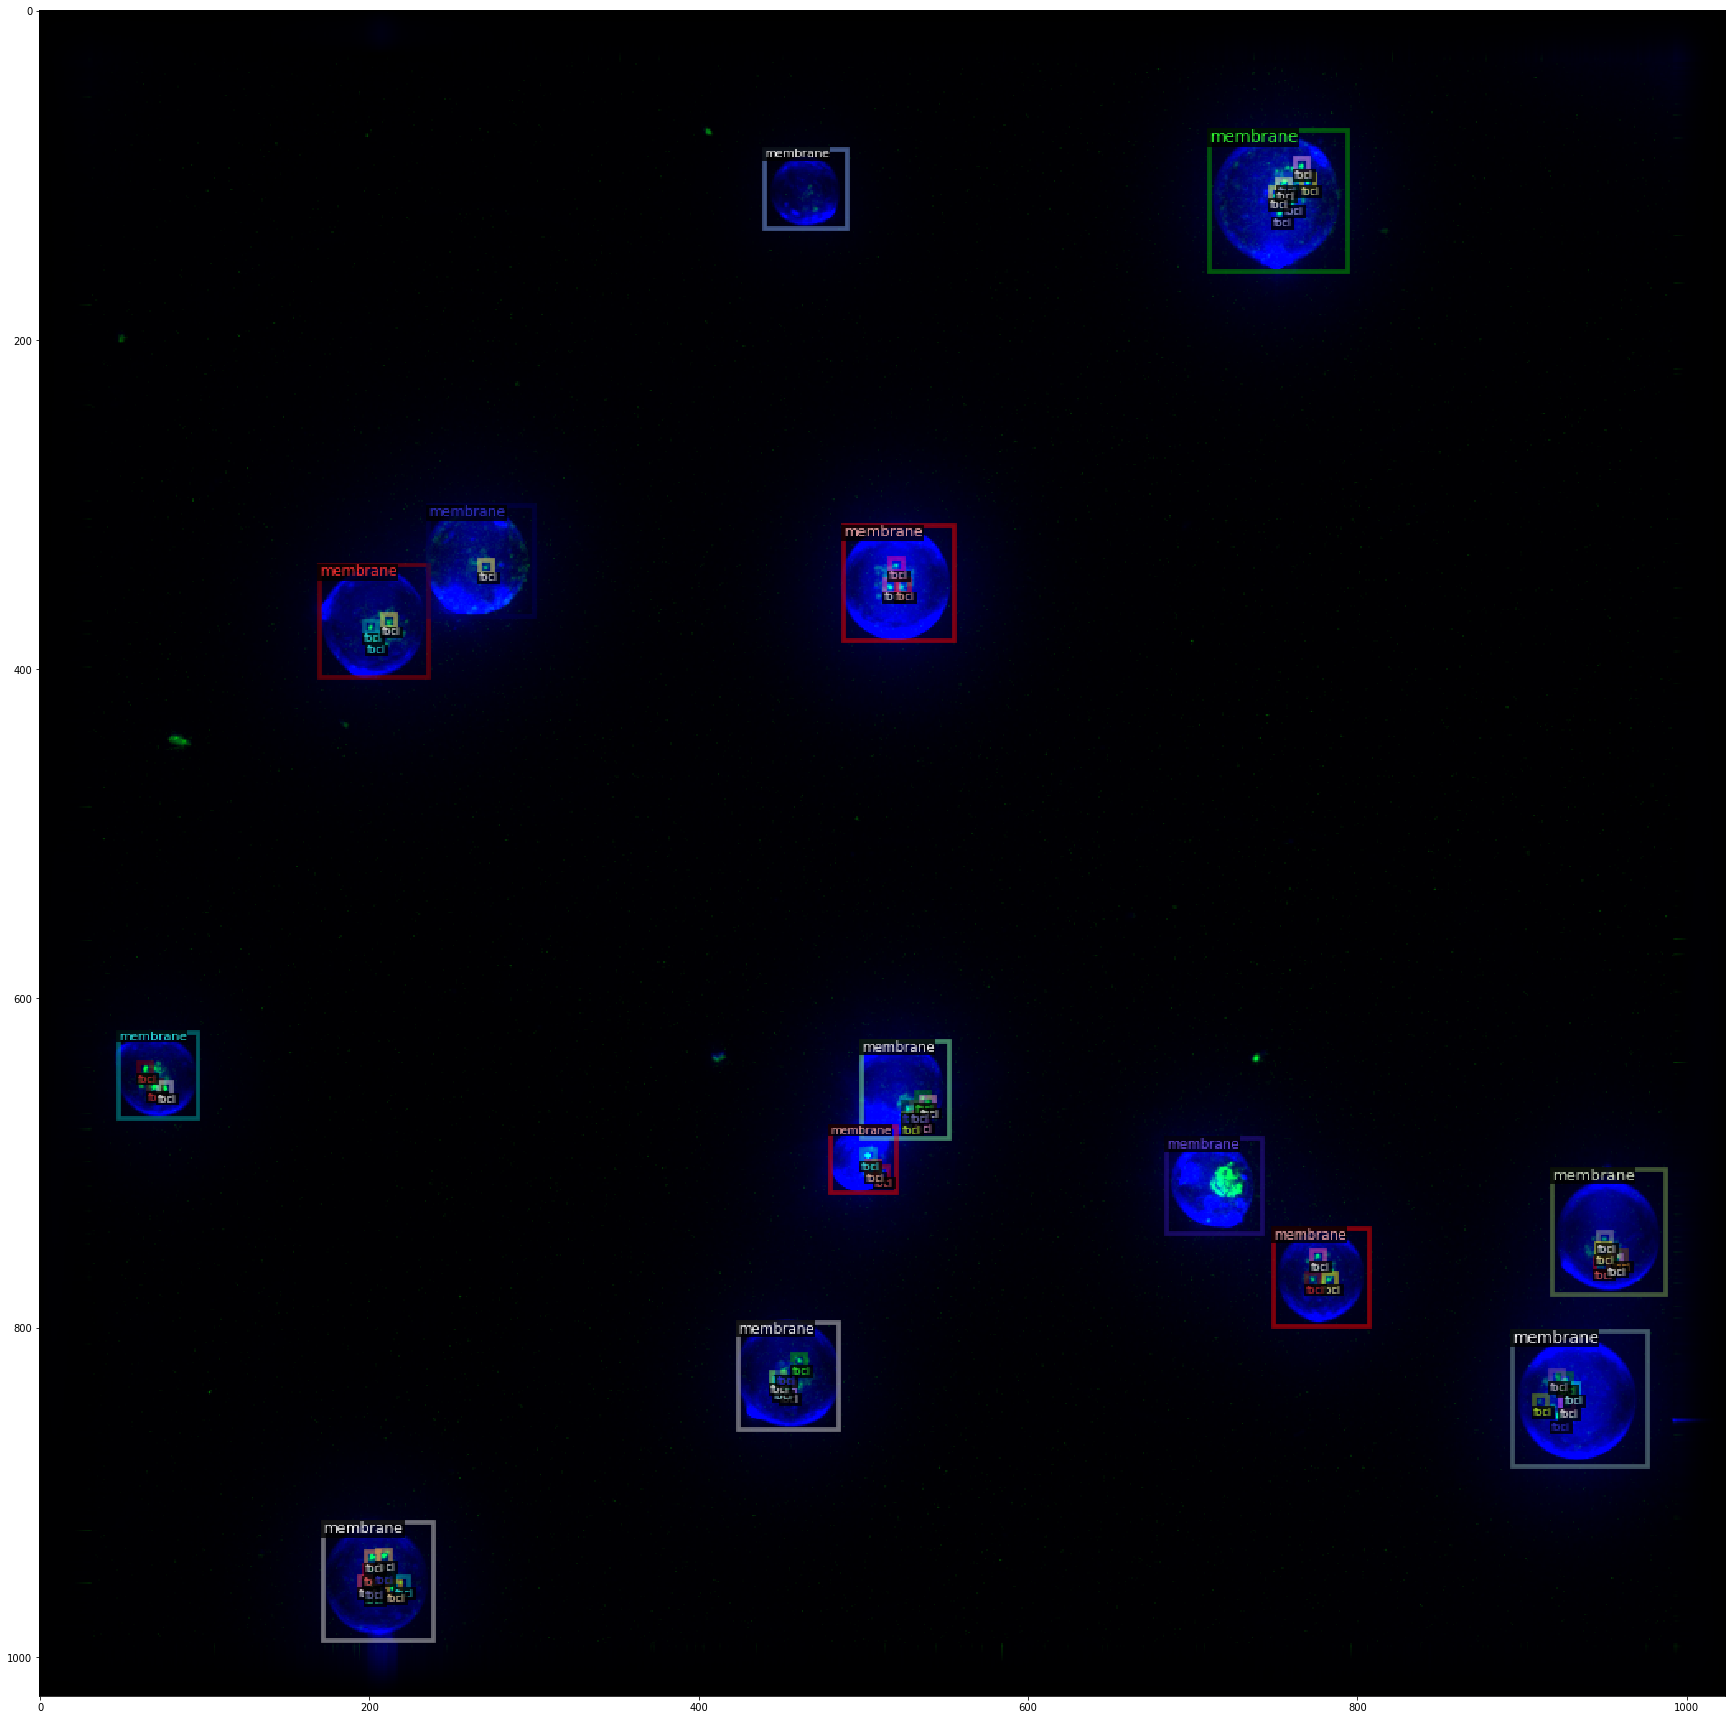

In [8]:
dictionary = random.sample(training_dictionaries, 1)[0]
image = skimage.io.imread(dictionary["file_name"])
visualizer = detectron2.utils.visualizer.Visualizer(image[:, :, ::-1], metadata=metadata_catalog)
visualization = visualizer.draw_dataset_dict(dictionary)
matplotlib.pyplot.figure(figsize=(24, 24))
skimage.io.imshow(visualization.get_image()[:, :, ::-1])

In [9]:
visualization.get_image().shape

(1024, 1024, 3)

In [10]:
cfg = detectron2.config.get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("training",)
cfg.SCALES = (2048, )
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 100000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

cfg.INPUT.MIN_SIZE_TRAIN = 1024
cfg.INPUT.MAX_SIZE_TRAIN = 1024

cfg.INPUT.MIN_SIZE_TEST = 1024
cfg.INPUT.MAX_SIZE_TEST = 1024

cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8, 16, 32, 64, 128, 256, 512]]

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [11]:
trainer = detectron2.engine.DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[06/26 10:29:16 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [ ]:
trainer.train()

[06/26 10:29:19 d2.engine.train_loop]: Starting training from iteration 0
[06/26 10:29:44 d2.utils.events]:  eta: 12:56:57  iter: 19  total_loss: 2.085  loss_cls: 1.007  loss_box_reg: 0.015  loss_rpn_cls: 0.689  loss_rpn_loc: 0.385  time: 0.5229  data_time: 0.7524  lr: 0.000005  max_mem: 15104M
[06/26 10:29:54 d2.utils.events]:  eta: 12:57:09  iter: 39  total_loss: 1.840  loss_cls: 0.768  loss_box_reg: 0.010  loss_rpn_cls: 0.686  loss_rpn_loc: 0.339  time: 0.5026  data_time: 0.0039  lr: 0.000010  max_mem: 15104M
[06/26 10:30:03 d2.utils.events]:  eta: 12:56:38  iter: 59  total_loss: 1.439  loss_cls: 0.478  loss_box_reg: 0.010  loss_rpn_cls: 0.670  loss_rpn_loc: 0.285  time: 0.4941  data_time: 0.0039  lr: 0.000015  max_mem: 15104M
[06/26 10:30:13 d2.utils.events]:  eta: 13:09:26  iter: 79  total_loss: 1.351  loss_cls: 0.369  loss_box_reg: 0.048  loss_rpn_cls: 0.658  loss_rpn_loc: 0.279  time: 0.4940  data_time: 0.0038  lr: 0.000020  max_mem: 15104M
[06/26 10:30:23 d2.utils.events]:  eta

In [15]:
checkpoints = glob.glob("output/*.pth")

checkpoint = os.path.basename(max(checkpoints, key=os.path.getctime))

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, checkpoint)

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # set the testing threshold for this model

cfg.TEST.DETECTIONS_PER_IMAGE = 200

cfg.DATASETS.TEST = ("test", )

predictor = detectron2.engine.DefaultPredictor(cfg)

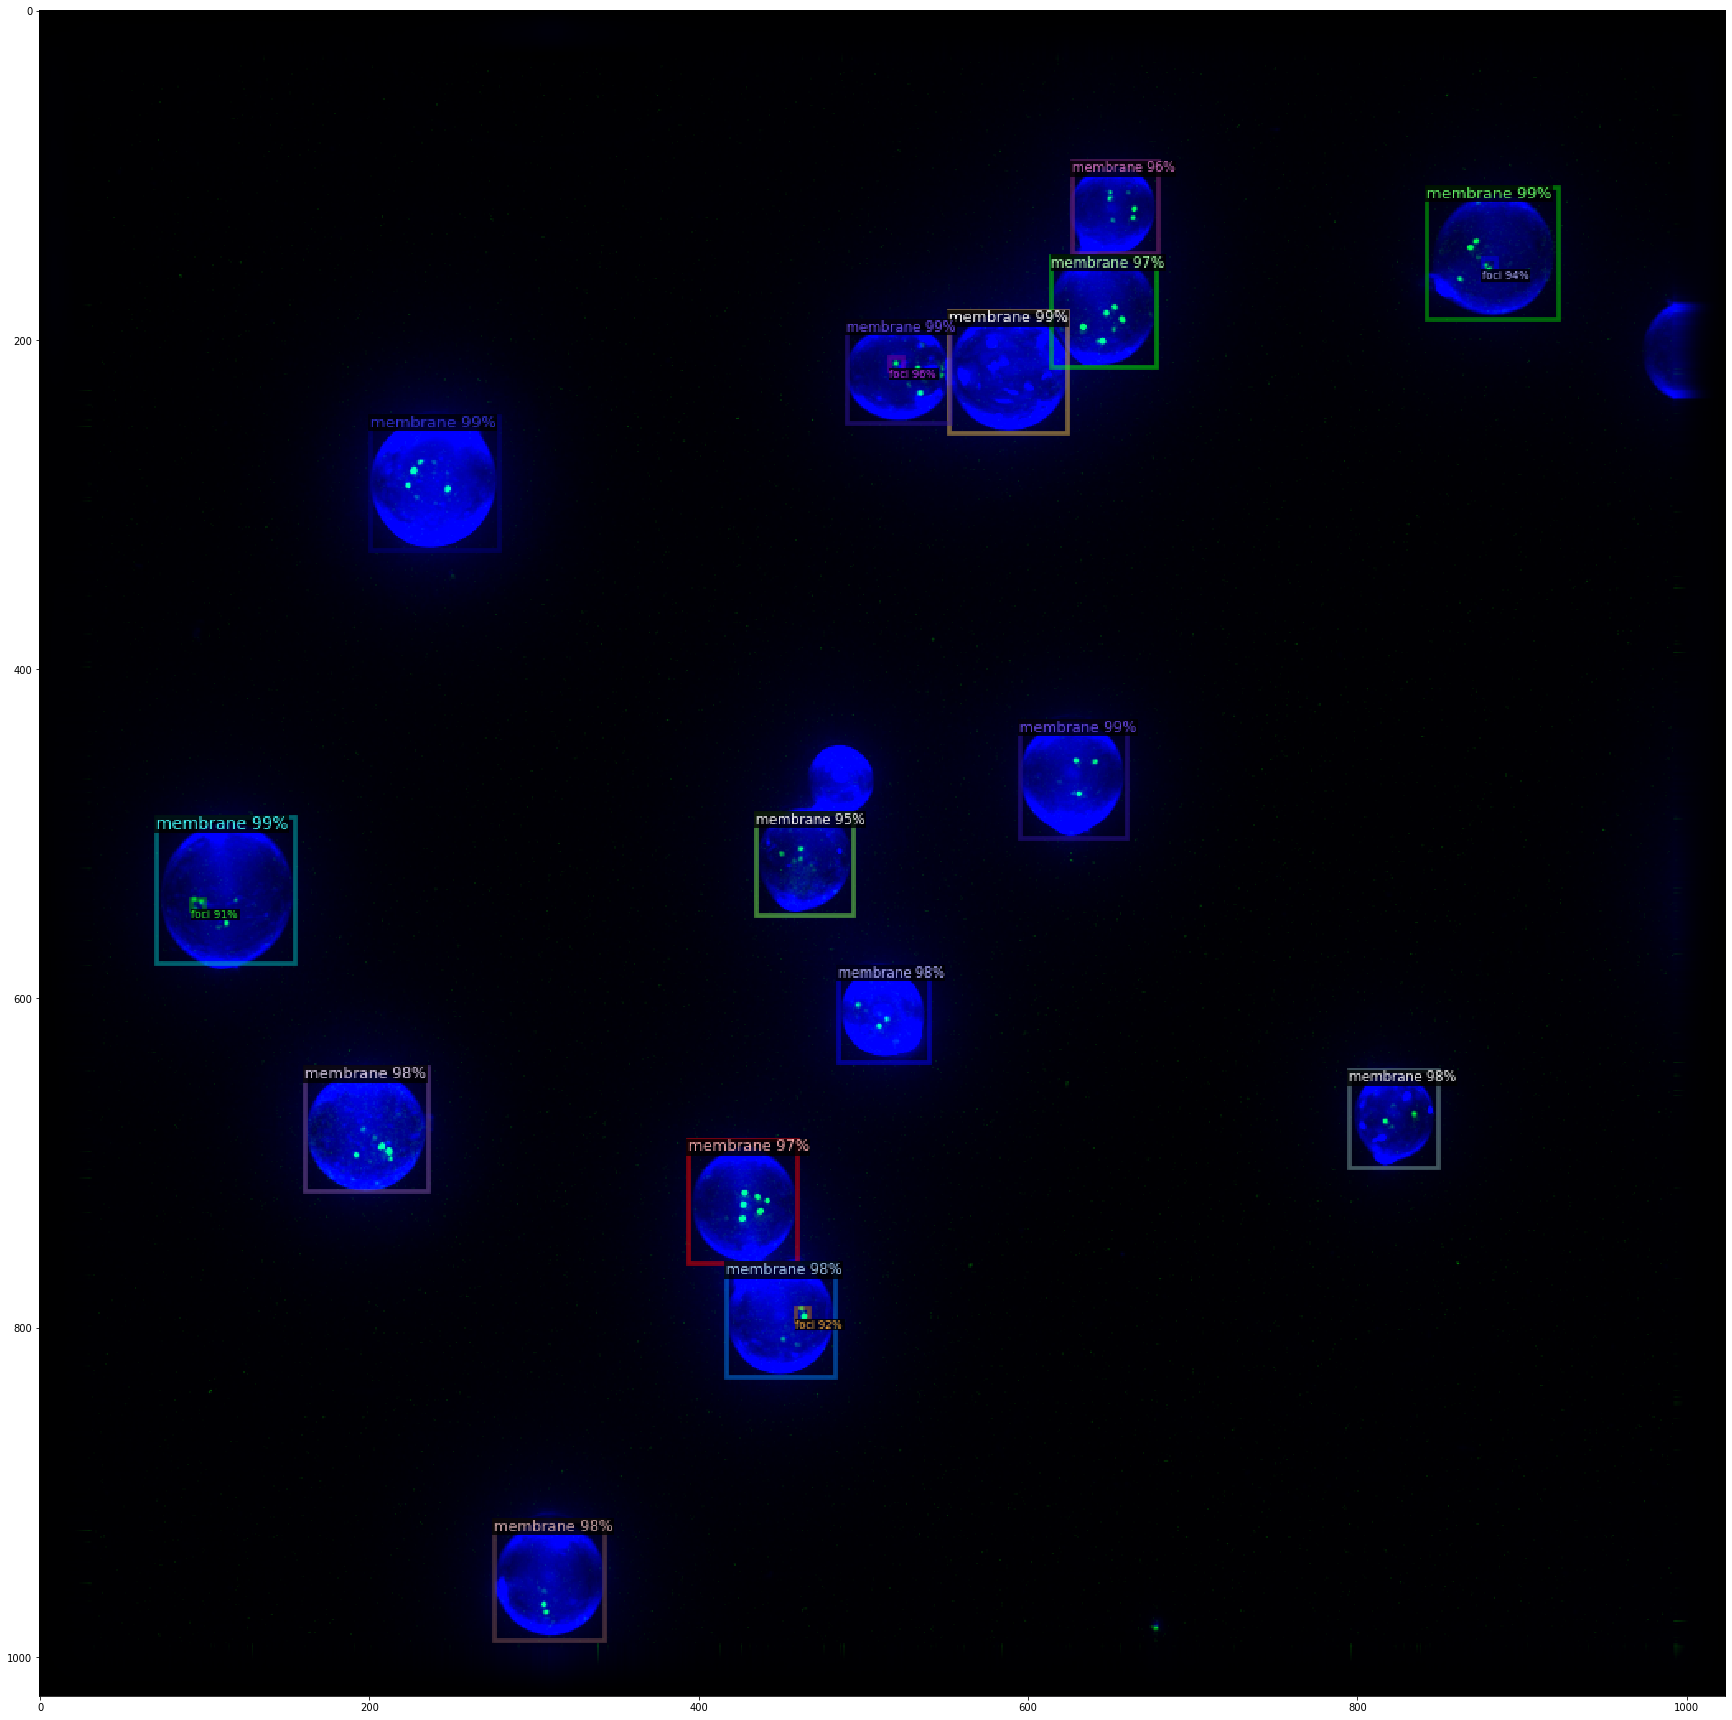

In [16]:
dataset_dicts = test_dictionaries
d = random.sample(dataset_dicts, 1)[0]
im = skimage.io.imread(d["file_name"])
outputs = predictor(im)
v = detectron2.utils.visualizer.Visualizer(im[:, :, ::-1],
               metadata=metadata_catalog, 
               scale=1.0
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
matplotlib.pyplot.figure(figsize=(24, 24))
skimage.io.imshow(v.get_image()[:, :, ::-1])

In [17]:
scores = outputs["instances"].scores.cpu().numpy()

In [ ]:
def to_prediction(data_row, bounding_box, category):    
    dictionary = {
        "uuid": str(uuid.uuid4()),
        "schemaId": None,
        "dataRow": { 
            "id": data_row.uid
        }
    }
    
    x, y, w, h = xyxy_to_xywh(bounding_box)

    if category == 0:
        dictionary["schemaId"] = feature_schema_id_0
        
        dictionary["bbox"] = { 
            "top": y, 
            "left": x, 
            "height": h, 
            "width": w 
        }
        
        return dictionary
    elif category == 1:
        dictionary["schemaId"] = feature_schema_id_1

        dictionary["point"] = {
            "x": x + (w // 2),
            "y": y + (h // 2)
        }
        
        return dictionary
    else:
        return
    
    return dictionary

def xyxy_to_xywh(bounding_box):
    return [
        bounding_box[0], 
        bounding_box[1], 
        bounding_box[2] - bounding_box[0], 
        bounding_box[3] - bounding_box[1]
    ]

def ontologies():
    query = f'query{{project(where:{{id:"{LABELBOX_PROJECT_ID}"}}){{ontology{{normalized}}}}}}'
    
    response = labelbox.Client(LABELBOX_API_KEY).execute(query)
    
    return response['project']['ontology']['normalized']['tools']

In [ ]:
feature_schema_id_0 = [ontology["featureSchemaId"] for ontology in ontologies() if ontology["name"] == "membrane"][0]
feature_schema_id_1 = [ontology["featureSchemaId"] for ontology in ontologies() if ontology["name"] == "foci"][0]

In [ ]:
datasets = project.datasets()

In [ ]:
import json
import glob

import ndjson

pathnames = glob.glob("../data/*.png")

predictions = []

for pathname in tqdm.notebook.tqdm_notebook(pathnames):
    external_id = os.path.basename(pathname)

    for dataset in datasets:    
        data_row = dataset.data_row_for_external_id(external_id)

    image = cv2.imread(pathname)

    outputs = predictor(image)

    predicted_bounding_boxes = outputs["instances"].get("pred_boxes")

    predicted_bounding_boxes = predicted_bounding_boxes.tensor.cpu().numpy().round().astype(numpy.uint16).tolist()

    predicted_categories = outputs["instances"].get("pred_classes")

    predicted_categories = predicted_categories.cpu().numpy().astype(numpy.uint8).tolist()

    for bounding_box, category in zip(predicted_bounding_boxes, predicted_categories):
        prediction = to_prediction(data_row, bounding_box, category)

        predictions += [prediction]
        
predicted_bounding_boxes = numpy.array(predicted_bounding_boxes)
predicted_categories = numpy.array(predicted_categories)

In [ ]:
import json
import glob

import ndjson

pathnames = glob.glob("../data/*.png")

predictions = []

external_id = os.path.basename(pathnames[0])

image = cv2.imread(pathname)

outputs = predictor(image)

predicted_bounding_boxes = outputs["instances"].get("pred_boxes")

predicted_bounding_boxes = predicted_bounding_boxes.tensor.cpu().numpy()

predicted_categories = outputs["instances"].get("pred_classes")

predicted_categories = predicted_categories.cpu().numpy()

predicted_bounding_boxes = numpy.array(predicted_bounding_boxes)
predicted_categories = numpy.array(predicted_categories)

In [ ]:
a_bounding_boxes = predicted_bounding_boxes[predicted_categories == 0].astype(numpy.int)
b_bounding_boxes = predicted_bounding_boxes[predicted_categories == 1].astype(numpy.int)

In [ ]:
image = skimage.exposure.equalize_adapthist(image)

In [ ]:
predicted_bounding_boxes_0[0]

In [ ]:
cropped.shape

In [ ]:
with open("prediction.ndjson", "w") as fp:
    for prediction in predictions:
        fp.write(json.dumps(prediction) + "\n")
        
with open("prediction.ndjson", "r") as fp:
    content = fp.read()

In [ ]:
def create_gist():
    GITHUB_ACCESS_TOKEN = "03caaeaebbee9e7d5a0e5feb308de753020897dd"

    import github

    github_user = github.Github(GITHUB_ACCESS_TOKEN).get_user()

    with open("prediction.ndjson", "r") as fp:
        content = fp.read()

    data = {
        "description": "",
        "files": {
            "prediction.ndjson": {
                "content": content
            }
        },
        "public": False,
    }

    data = json.dumps(data)

    response = requests.patch(
        "https://api.github.com/gists/4fb414cf67dbcb96dc49ecef4276ff90", 
        data=data,
        headers={"Authorization": f"token {GITHUB_ACCESS_TOKEN}"}, 
        params={"scope": "gist"}
    )

    return json.loads(response.content)["files"]["prediction.ndjson"]["raw_url"]

fileUrl = create_gist()

In [ ]:
client = graphqlclient.GraphQLClient('https://api.labelbox.com/graphql')

client.inject_token(f'Bearer {LABELBOX_API_KEY}')

name = str(uuid.uuid4())

query = f'mutation{{createBulkImportRequest(data:{{projectId:"ck9ogaou38nlg0758znmfklt4",name:"{name}",fileUrl:"{fileUrl}"}}){{id}}}}'

data = client.execute(query)

In [ ]:
query = f'query{{bulkImportRequest(where:{{projectId:"ck9ogaou38nlg0758znmfklt4",name:"{name}"}}){{id,name,state,statusFileUrl,errorFileUrl}}}}'

response = client.execute(query)

response = json.loads(response)

In [ ]:
response = requests.get(response["data"]["bulkImportRequest"]["statusFileUrl"])

In [ ]:
x1 - x0, y1 - y0

In [ ]:
image.min()

In [ ]:
crop.shape

In [ ]:
rendered.shape

In [ ]:
dataset_dicts = test_dictionaries
d = random.sample(dataset_dicts, 1)[0]
im = skimage.io.imread(d["file_name"])
outputs = predictor(im)
v = detectron2.utils.visualizer.Visualizer(im[:, :, ::-1],
               metadata=metadata_catalog, 
               scale=1.0
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
matplotlib.pyplot.figure(figsize=(8, 8))

x0, y0, x1, y1 = box_coord
width = x1 - x0
height = y1 - y0


# x0, y0, x1, y1 = numpy.array([412.7072, 325.0351, 500.76276, 417.49774]).astype(numpy.int)

# skimage.io.imshow(rendered[x0:x1, y0:y1])

In [ ]:
for dictionary in test_dictionaries:
    image = skimage.io.imread(dictionary["file_name"])

    outputs = predictor(image)

    predicted_bounding_boxes = outputs["instances"].get("pred_boxes").tensor.cpu().numpy()
    predicted_categories = outputs["instances"].get("pred_classes").cpu().numpy()
    predicted_scores = outputs["instances"].get("scores").cpu().numpy()

    predicted_bounding_boxes = predicted_bounding_boxes[predicted_scores > 0.9999]
    predicted_categories = predicted_categories[predicted_scores > 0.9999]

    predicted_bounding_boxes_0 = predicted_bounding_boxes[predicted_categories == 0].astype(numpy.int)
    predicted_bounding_boxes_1 = predicted_bounding_boxes[predicted_categories == 1].astype(numpy.int)

    for predicted_bounding_box in predicted_bounding_boxes_0:
        x0, y0, x1, y1 = predicted_bounding_box

        pathname = f"data/0/{uuid.uuid4()}.png"

        crop = image[y0:y1, x0:x1]

        skimage.io.imsave(pathname, crop)

In [ ]:
for dictionary in training_dictionaries:
    image = skimage.io.imread(dictionary["file_name"])

    outputs = predictor(image)

    predicted_bounding_boxes = outputs["instances"].get("pred_boxes").tensor.cpu().numpy()
    predicted_categories = outputs["instances"].get("pred_classes").cpu().numpy()
    predicted_scores = outputs["instances"].get("scores").cpu().numpy()

    predicted_bounding_boxes = predicted_bounding_boxes[predicted_scores > 0.9999]
    predicted_categories = predicted_categories[predicted_scores > 0.9999]

    predicted_bounding_boxes = predicted_bounding_boxes[predicted_categories == 1].astype(numpy.int)

    for predicted_bounding_box in predicted_bounding_boxes_0:
        x0, y0, x1, y1 = predicted_bounding_box

        pathname = f"data/0/{uuid.uuid4()}.png"

        crop = image[y0:y1, x0:x1]

        skimage.io.imsave(pathname, crop)